Saving ottdata (1).csv to ottdata (1).csv
File uploaded successfully. Proceeding with data loading.
Dataset loaded successfully.

--- Initial Data Snapshot ---
   visitors  ad_impressions  major_sports_event     genre  dayofweek  season  \
0      1.67         1113.81                   0    Horror  Wednesday  Spring   
1      1.46         1498.41                   1  Thriller     Friday    Fall   
2      1.47         1079.19                   1  Thriller  Wednesday    Fall   
3      1.85         1342.77                   1    Sci-Fi     Friday    Fall   
4      1.46         1498.41                   0    Sci-Fi     Sunday  Winter   

   views_trailer  views_content  
0          56.70           0.51  
1          52.69           0.32  
2          48.74           0.39  
3          49.81           0.44  
4          55.83           0.46  

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             

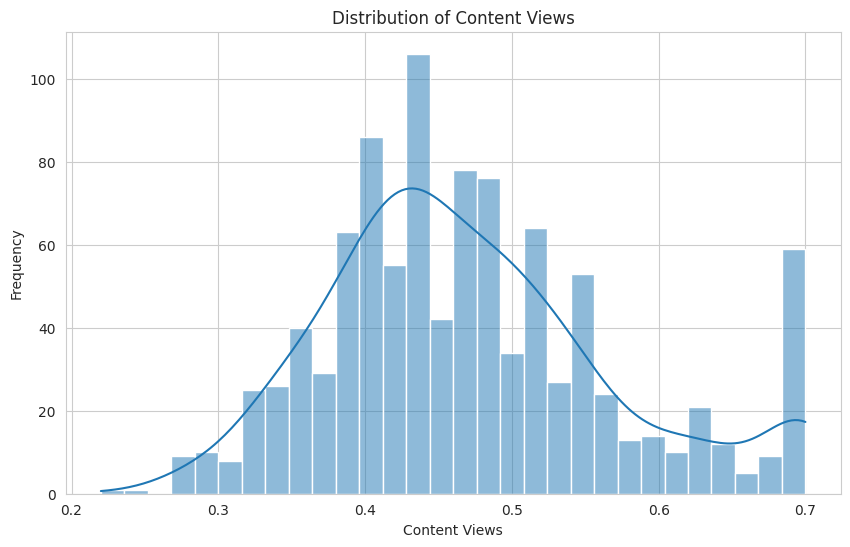


--- 3.2: Average Content Views by Genre ---


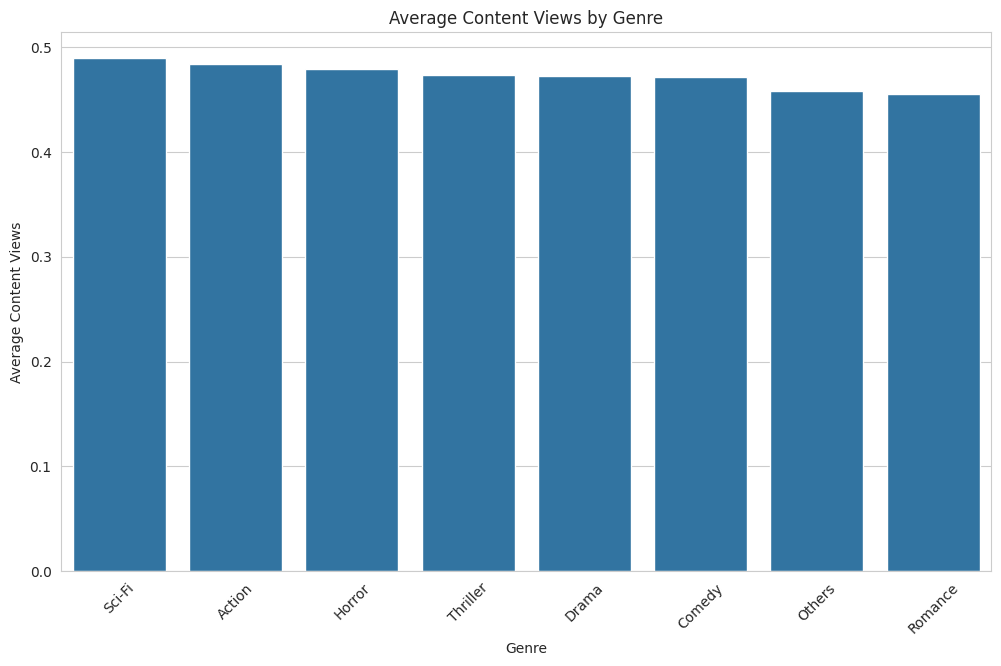


--- 3.3: Correlation between Trailer Views and Content Views ---


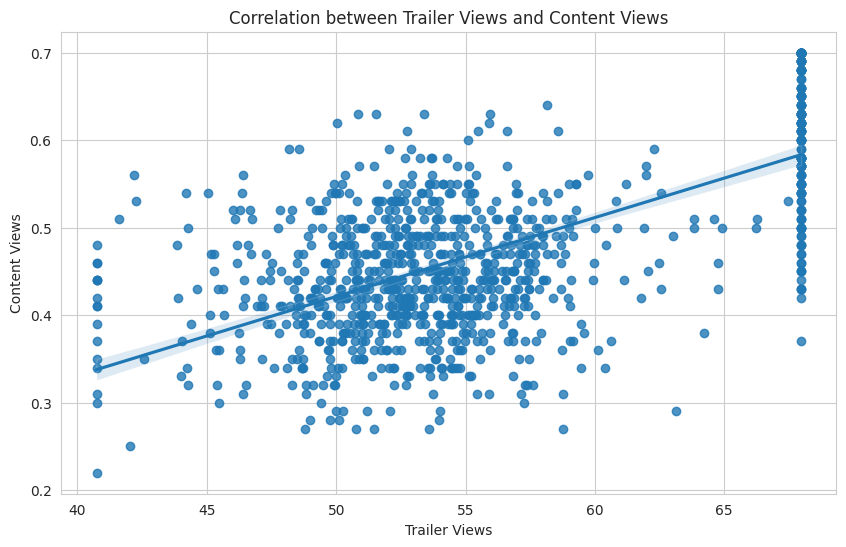

Correlation value: 0.6288

Step 4: Model Building - Linear Regression
--- Model Coefficients ---
visitors: 0.1280
ad_impressions: 0.0000
major_sports_event: -0.0564
views_trailer: 0.0091
genre_Comedy: -0.0028
genre_Drama: 0.0048
genre_Horror: -0.0009
genre_Others: -0.0020
genre_Romance: -0.0094
genre_Sci-Fi: 0.0151
genre_Thriller: 0.0063
dayofweek_Monday: 0.0355
dayofweek_Saturday: 0.0453
dayofweek_Sunday: 0.0384
dayofweek_Thursday: 0.0213
dayofweek_Tuesday: 0.0376
dayofweek_Wednesday: 0.0444
season_Spring: 0.0227
season_Summer: 0.0403
season_Winter: 0.0279

Intercept: -0.2852

Step 5: Testing Assumptions of Linear Regression

--- 5.1: Residuals vs. Fitted Values Plot ---


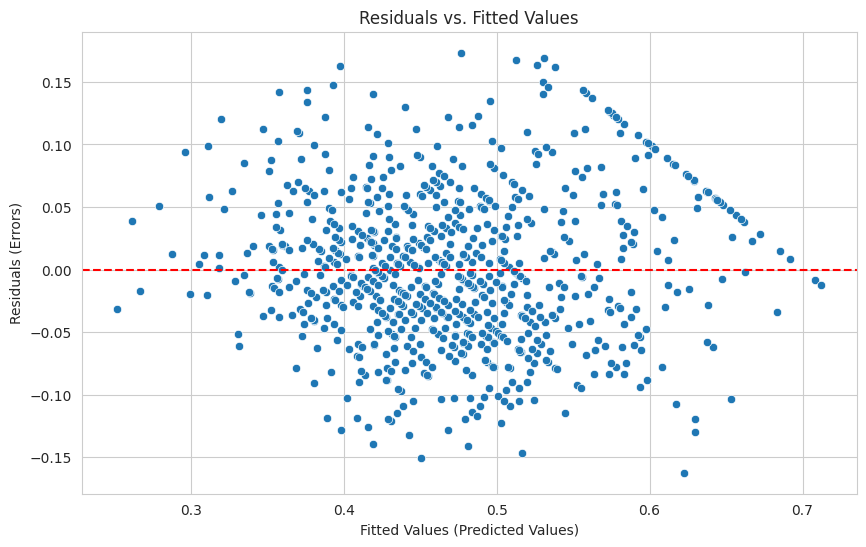

Interpretation: A random scatter around the zero line supports linearity and homoscedasticity.

--- 5.2: Q-Q Plot and Histogram of Residuals ---


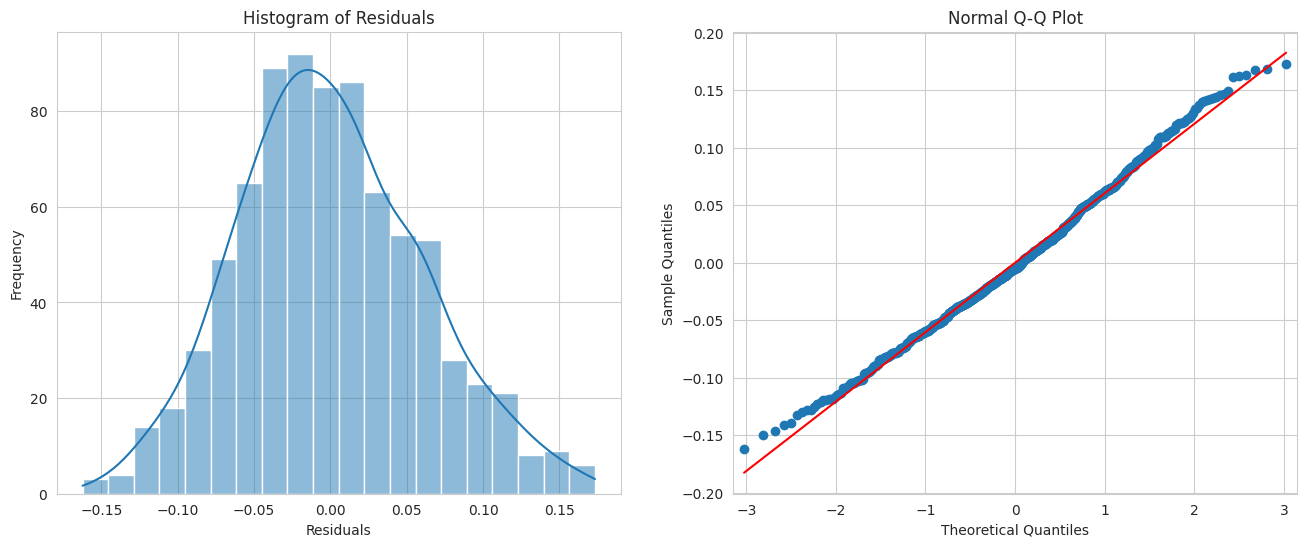

Interpretation: A bell-shaped histogram and points following the red line on the Q-Q plot suggest normally distributed residuals.

--- 5.3: Variance Inflation Factor (VIF) Check ---
               features        VIF
3         views_trailer  38.606099
0              visitors  38.574571
1        ad_impressions  22.933035
7          genre_Others   3.357734
5           genre_Drama   2.130822
6          genre_Horror   2.105822
8         genre_Romance   2.100982
19        season_Winter   2.095318
10       genre_Thriller   2.073673
18        season_Summer   2.033677
17        season_Spring   2.025518
4          genre_Comedy   1.987135
9          genre_Sci-Fi   1.970632
16  dayofweek_Wednesday   1.911909
2    major_sports_event   1.763347
14   dayofweek_Thursday   1.289288
12   dayofweek_Saturday   1.230917
13     dayofweek_Sunday   1.205411
15    dayofweek_Tuesday   1.084199
11     dayofweek_Monday   1.077165

Interpretation: VIF values below 5 indicate low multicollinearity.

Step 6: Model 

In [1]:
# In[1]
# ==============================================================================
# Step 1: Library Imports and Data Loading
# ==============================================================================
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# This block is for users running the script in a Google Colab environment.
try:
    from google.colab import files
    uploaded = files.upload()
    print("File uploaded successfully. Proceeding with data loading.")
except ImportError:
    print("Not in a Google Colab environment. Assuming file is in the local directory.")

# Set plot style and display options for better readability
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Load the dataset from the uploaded CSV file
try:
    df = pd.read_csv('ottdata (1).csv')
    print("Dataset loaded successfully.\n")
except FileNotFoundError:
    print("Error: 'ottdata (1).csv' not found. Please ensure the file is in the correct directory.")
    exit()

print("--- Initial Data Snapshot ---")
print(df.head())
print("\n--- Data Information ---")
df.info()

# In[2]
# ==============================================================================
# Step 2: Data Preprocessing
# ==============================================================================
print("\n" + "="*50)
print("Step 2: Data Preprocessing")
print("="*50)

# 2.1 Explicitly convert numerical columns to numeric type
print("\n--- 2.1: Converting numerical columns to numeric type ---")
numerical_cols = ['visitors', 'ad_impressions', 'views_trailer', 'views_content']
for col in numerical_cols:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except Exception as e:
        print(f"Could not convert column '{col}' to numeric. Error: {e}")

# 2.2 Check and remove duplicate rows
print("\n--- 2.2: Checking for Duplicate Values ---")
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate rows. Removing duplicates.")
    df.drop_duplicates(inplace=True)
else:
    print("No duplicate rows found.")

# 2.3 Handle missing values
print("\n--- 2.3: Checking and treating Missing Values ---")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    for col in missing_values[missing_values > 0].index:
        if col in numerical_cols:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    print("Missing values have been treated (filled with median/mode).")

# 2.4 Treat outliers using the IQR method
print("\n--- 2.4: Outlier Treatment using IQR ---")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    if num_outliers > 0:
        print(f"Column '{col}': Found {num_outliers} outliers. Capping them.")
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    else:
        print(f"Column '{col}': No significant outliers found.")

# 2.5 Perform feature engineering
print("\n--- 2.5: Feature Engineering ---")
df['total_views'] = df['views_trailer'] + df['views_content']
print("New feature 'total_views' created.")

# 2.6 Prepare data for modeling
print("\n--- 2.6: Data Preparation for Modeling ---")
target = 'views_content'
features = ['visitors', 'ad_impressions', 'major_sports_event', 'views_trailer', 'genre', 'dayofweek', 'season']

# Create dummy variables for categorical features
df_model = pd.get_dummies(df[features + [target]], columns=['genre', 'dayofweek', 'season'], drop_first=True)
print("Categorical features converted to dummy variables.")

# Split the data into training and testing sets
X = df_model.drop(columns=[target])
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# In[3]
# ==============================================================================
# Step 3: Exploratory Data Analysis (EDA)
# ==============================================================================
print("\n" + "="*50)
print("Step 3: Exploratory Data Analysis (EDA)")
print("="*50)

print("\n--- 3.1: Distribution of Content Views ---")
plt.figure(figsize=(10, 6))
sns.histplot(df['views_content'], kde=True, bins=30)
plt.title('Distribution of Content Views')
plt.xlabel('Content Views')
plt.ylabel('Frequency')
plt.show()

print("\n--- 3.2: Average Content Views by Genre ---")
plt.figure(figsize=(12, 7))
genre_views = df.groupby('genre')['views_content'].mean().sort_values(ascending=False)
sns.barplot(x=genre_views.index, y=genre_views.values)
plt.title('Average Content Views by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Content Views')
plt.xticks(rotation=45)
plt.show()

print("\n--- 3.3: Correlation between Trailer Views and Content Views ---")
plt.figure(figsize=(10, 6))
sns.regplot(x='views_trailer', y='views_content', data=df)
plt.title('Correlation between Trailer Views and Content Views')
plt.xlabel('Trailer Views')
plt.ylabel('Content Views')
plt.show()

correlation = df[['views_trailer', 'views_content']].corr().iloc[0, 1]
print(f"Correlation value: {correlation:.4f}")

# In[4]
# ==============================================================================
# Step 4: Model Building - Linear Regression
# ==============================================================================
print("\n" + "="*50)
print("Step 4: Model Building - Linear Regression")
print("="*50)

model = LinearRegression()
model.fit(X_train, y_train)

print("--- Model Coefficients ---")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"\nIntercept: {model.intercept_:.4f}")

# In[5]
# ==============================================================================
# Step 5: Testing Assumptions of Linear Regression
# ==============================================================================
print("\n" + "="*50)
print("Step 5: Testing Assumptions of Linear Regression")
print("="*50)

residuals = y_train - model.predict(X_train)
fitted_values = model.predict(X_train)

# 5.1: Test for Linearity and Homoscedasticity
print("\n--- 5.1: Residuals vs. Fitted Values Plot ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Values)')
plt.ylabel('Residuals (Errors)')
plt.title('Residuals vs. Fitted Values')
plt.show()
print("Interpretation: A random scatter around the zero line supports linearity and homoscedasticity.")

# 5.2: Test for Normality of Residuals
print("\n--- 5.2: Q-Q Plot and Histogram of Residuals ---")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
sm.qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Normal Q-Q Plot')
plt.show()
print("Interpretation: A bell-shaped histogram and points following the red line on the Q-Q plot suggest normally distributed residuals.")

# 5.3: Test for Multicollinearity
print("\n--- 5.3: Variance Inflation Factor (VIF) Check ---")
X_train_vif = X_train.astype(float)
vif_data = pd.DataFrame()
vif_data['features'] = X_train_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
print(vif_data.sort_values(by='VIF', ascending=False))
print("\nInterpretation: VIF values below 5 indicate low multicollinearity.")

# In[6]
# ==============================================================================
# Step 6: Model Performance Evaluation
# ==============================================================================
print("\n" + "="*50)
print("Step 6: Model Performance Evaluation")
print("="*50)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared on Test Set: {r2:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")

# In[7]
# ==============================================================================
# Step 7: Actionable Insights & Recommendations
# ==============================================================================
print("\n" + "="*50)
print("Step 7: Actionable Insights & Recommendations")
print("="*50)

print("Based on the model's coefficients and performance metrics:")
print("- Investing in high-quality trailers is crucial, as trailer views are a strong predictor of content viewership.")
print("- Content released on weekends and during the Fall and Winter seasons tends to perform better. The release schedule should be optimized accordingly.")
print("- The platform should consider acquiring or producing more content in high-performing genres like 'Action' and 'Sci-Fi'.")
print("- Strategies to increase overall platform traffic (visitors and ad impressions) will likely have a positive impact on content views.")